In [1]:
import pandas as pd
import numpy as np
import requests
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.manifold import TSNE

from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score
from clustergram import Clustergram
import urbangrammar_graphics as ugg
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Подготовка витрины данных

In [2]:
# Загрузим данные
contracts = pd.read_excel("data/CASE_CONTRACTS.xlsx")
clients = pd.read_excel("data/CASE_CLIENTS.xlsx")
losses = pd.read_excel("data/CASE_LOSSES.xlsx")

In [3]:
# Посмотрим на размеры датафреймов
dfs = [contracts, clients, losses]

for df in dfs:
    print(df.shape)

(3711, 10)
(3711, 6)
(45, 4)


In [4]:
# Объединим данные в одну таблицу
data = contracts.merge(
        clients, on="client_id", how="left").merge(
        losses, on="client_id", how="left")
data.head()

,contract_id,contract_num,product_name,client_id,contract_status,currency_name,duration,country,price,insurance_amount,last_name,first_name,middle_name,age,sex,loss_id,loss_name,loss_payout_amt
0,21111219,ТТЕ7227715*****,Страхование путешественников,10161870404,Действует,Российский рубль,10,Беларусь,1096,2000000,А*****,Х*****,А*****,20,M,NaN,NaN,NaN
1,21111381,ТТЕ7227715*****,Страхование путешественников,1017159879,Действует,Российский рубль,7,Индонезия,1918,5000000,З*****,Х*****,М*****,55,M,NaN,NaN,NaN
2,21112353,БАДАМСТЕ55*****,Страхование путешественников,10161883357,Действует,Российский рубль,10,Беларусь,1096,2000000,Б*****,В*****,Щ*****,61,F,NaN,NaN,NaN
3,21113224,ТТЕ7227715*****,Страхование путешественников,100766461,Действует,Российский рубль,14,Грузия,1534,2000000,И*****,У*****,Н*****,25,M,NaN,NaN,NaN
4,21113292,ТТЕ7227715*****,Страхование путешественников,10171604758,Действует,Российский рубль,7,Аргентина,1918,5000000,З*****,Ч*****,Г*****,33,M,NaN,NaN,NaN


In [5]:
# Напишем функцию, которая будет получать курс валют по отношению к доллару на сегодняшний день. Для этого воспользуемся API сервиса Open Exchange Rates.

def get_latest_exchange_rate():
    api_key = os.getenv("OPEN_EXCHANGE_RATES_API")
    base_currency = "USD"
    endpoint = f"https://open.er-api.com/v6/latest/{base_currency}"
    response = requests.get(endpoint, params={"apikey": api_key})
    if response.status_code == 200:
        data = response.json()
        return data["rates"]
    else:
        raise Exception("Failed to fetch exchange rates from the API")
    

# Сохраним курс доллара к рублю в переменную usd_rub_rate.    
exchange_rates = get_latest_exchange_rate()
usd_rub_rate = exchange_rates["RUB"]

# Напишем функцию, которая будет конвертировать сумму в рублях в доллары.

def converter(amount, currency):
    if currency == "Российский рубль":
        if amount > 0:
            return int(amount / usd_rub_rate)
    else:
        return amount
    
    
# Применим функцию к столбцам price, insurance_amount и loss_payout_amt.
data["price_usd"] = data.apply(lambda row: converter(row["price"], row["currency_name"]), axis=1)
data["insurance_amount_usd"] = data.apply(lambda row: converter(row["insurance_amount"], row["currency_name"]), axis=1)
data["loss_payout_amt_usd"] = data.apply(lambda row: converter(row["loss_payout_amt"], row["currency_name"]), axis=1)
data.head()

,contract_id,contract_num,product_name,client_id,contract_status,currency_name,duration,country,price,insurance_amount,...,first_name,middle_name,age,sex,loss_id,loss_name,loss_payout_amt,price_usd,insurance_amount_usd,loss_payout_amt_usd
0,21111219,ТТЕ7227715*****,Страхование путешественников,10161870404,Действует,Российский рубль,10,Беларусь,1096,2000000,...,Х*****,А*****,20,M,NaN,NaN,NaN,11,21353,NaN
1,21111381,ТТЕ7227715*****,Страхование путешественников,1017159879,Действует,Российский рубль,7,Индонезия,1918,5000000,...,Х*****,М*****,55,M,NaN,NaN,NaN,20,53382,NaN
2,21112353,БАДАМСТЕ55*****,Страхование путешественников,10161883357,Действует,Российский рубль,10,Беларусь,1096,2000000,...,В*****,Щ*****,61,F,NaN,NaN,NaN,11,21353,NaN
3,21113224,ТТЕ7227715*****,Страхование путешественников,100766461,Действует,Российский рубль,14,Грузия,1534,2000000,...,У*****,Н*****,25,M,NaN,NaN,NaN,16,21353,NaN
4,21113292,ТТЕ7227715*****,Страхование путешественников,10171604758,Действует,Российский рубль,7,Аргентина,1918,5000000,...,Ч*****,Г*****,33,M,NaN,NaN,NaN,20,53382,NaN


In [6]:
# Напишем функцию, которая будет возвращать инициалы в формате Ф.И.О.:

def get_initials(last_name, first_name, middle_name):
    initials = ""
    if pd.notnull(last_name):
        initials += last_name[0] + "."
    if pd.notnull(first_name):
        initials += " " + first_name[0] + "."    
    if pd.notnull(middle_name):
        initials += " " + middle_name[0] + "."
    return initials


# Создадим новый столбец с инициалами:
data["initials"] = data.apply(lambda row: get_initials(row["last_name"], row["first_name"], row["middle_name"]), axis=1)
data.head()

,contract_id,contract_num,product_name,client_id,contract_status,currency_name,duration,country,price,insurance_amount,...,middle_name,age,sex,loss_id,loss_name,loss_payout_amt,price_usd,insurance_amount_usd,loss_payout_amt_usd,initials
0,21111219,ТТЕ7227715*****,Страхование путешественников,10161870404,Действует,Российский рубль,10,Беларусь,1096,2000000,...,А*****,20,M,NaN,NaN,NaN,11,21353,NaN,А. Х. А.
1,21111381,ТТЕ7227715*****,Страхование путешественников,1017159879,Действует,Российский рубль,7,Индонезия,1918,5000000,...,М*****,55,M,NaN,NaN,NaN,20,53382,NaN,З. Х. М.
2,21112353,БАДАМСТЕ55*****,Страхование путешественников,10161883357,Действует,Российский рубль,10,Беларусь,1096,2000000,...,Щ*****,61,F,NaN,NaN,NaN,11,21353,NaN,Б. В. Щ.
3,21113224,ТТЕ7227715*****,Страхование путешественников,100766461,Действует,Российский рубль,14,Грузия,1534,2000000,...,Н*****,25,M,NaN,NaN,NaN,16,21353,NaN,И. У. Н.
4,21113292,ТТЕ7227715*****,Страхование путешественников,10171604758,Действует,Российский рубль,7,Аргентина,1918,5000000,...,Г*****,33,M,NaN,NaN,NaN,20,53382,NaN,З. Ч. Г.


In [7]:
# Оставим данные только по действующим договорам
data = data[data["contract_status"] == "Действует"]

# Удалим ненужные столбцы
data = data.drop(["contract_id", "product_name", "contract_status", "currency_name",
                  "price", "insurance_amount", "last_name", "first_name", "middle_name",
                  "loss_id", "loss_name", "loss_payout_amt", "contract_num"], axis=1)

In [8]:
# Переместим столбец с инициалами в начало таблицы
cols = list(data.columns)
cols = [cols[-1]] + cols[:-1]
data = data[cols]
data.head()

,initials,client_id,duration,country,age,sex,price_usd,insurance_amount_usd,loss_payout_amt_usd
0,А. Х. А.,10161870404,10,Беларусь,20,M,11,21353,NaN
1,З. Х. М.,1017159879,7,Индонезия,55,M,20,53382,NaN
2,Б. В. Щ.,10161883357,10,Беларусь,61,F,11,21353,NaN
3,И. У. Н.,100766461,14,Грузия,25,M,16,21353,NaN
4,З. Ч. Г.,10171604758,7,Аргентина,33,M,20,53382,NaN


In [9]:
# Сохраним отчёт в формате xlsx
data.to_excel("data/insurance_data.xlsx", index=False)

# Предобработка данных

In [10]:
# Выведем информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3315 entries, 0 to 3710
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   initials              3315 non-null   object 
 1   client_id             3315 non-null   int64  
 2   duration              3315 non-null   int64  
 3   country               3315 non-null   object 
 4   age                   3315 non-null   int64  
 5   sex                   3315 non-null   object 
 6   price_usd             3315 non-null   int64  
 7   insurance_amount_usd  3315 non-null   int64  
 8   loss_payout_amt_usd   45 non-null     float64
dtypes: float64(1), int64(5), object(3)
memory usage: 259.0+ KB


In [11]:
# Заменим пропуски в столбце с потерями на 0 и изменим тип данных на int
data["loss_payout_amt_usd"] = data["loss_payout_amt_usd"].fillna(0).astype('int')

# Проверим, что пропусков больше нет
data.isnull().sum()

initials                0
client_id               0
duration                0
country                 0
age                     0
sex                     0
price_usd               0
insurance_amount_usd    0
loss_payout_amt_usd     0
dtype: int64

In [12]:
# Закодируем категориальные признаки
categorical_features = ["country", "sex"]

for feature in categorical_features:
    encoder = LabelEncoder()
    encoder.fit(data[feature])
    data[feature] = encoder.transform(data[feature])

# Посмотрим на результат
data.head()

,initials,client_id,duration,country,age,sex,price_usd,insurance_amount_usd,loss_payout_amt_usd
0,А. Х. А.,10161870404,10,3,20,1,11,21353,0
1,З. Х. М.,1017159879,7,9,55,1,20,53382,0
2,Б. В. Щ.,10161883357,10,3,61,0,11,21353,0
3,И. У. Н.,100766461,14,7,25,1,16,21353,0
4,З. Ч. Г.,10171604758,7,1,33,1,20,53382,0


In [13]:
# Нипишем функцию, которая с помошью IsolationForest найдет аномалии

def find_anomalies(data, contamination=0.1):
    model = IsolationForest(contamination=contamination)
    model.fit(data)
    pred = model.predict(data)
    return pred


# Найдем аномалии
data_anomaly = data.drop(["initials", "client_id"], axis=1)
anomalies = pd.Series(find_anomalies(data_anomaly))

# Создадим новый признак anomaly, где 1 - аномалия, 0 - нет
data_anomaly["anomaly"] = anomalies.apply(lambda x: 1 if x == -1 else 0)
data_anomaly.head()

,duration,country,age,sex,price_usd,insurance_amount_usd,loss_payout_amt_usd,anomaly
0,10,3,20,1,11,21353,0,0.0
1,7,9,55,1,20,53382,0,0.0
2,10,3,61,0,11,21353,0,1.0
3,14,7,25,1,16,21353,0,0.0
4,7,1,33,1,20,53382,0,0.0


In [14]:
# Посмотрим на количество аномалий
data_anomaly["anomaly"].value_counts()

0.0    2632
1.0     287
Name: anomaly, dtype: int64

In [15]:
data_anomaly[data_anomaly["anomaly"] == 1]

,duration,country,age,sex,price_usd,insurance_amount_usd,loss_payout_amt_usd,anomaly
2,10,3,61,0,11,21353,0,1.0
16,10,15,61,0,17,32029,1067,1.0
18,10,3,67,1,11,21353,0,1.0
25,30,15,55,0,52,32029,0,1.0
32,10,15,67,0,17,32029,533,1.0
...,...,...,...,...,...,...,...,...
3210,10,13,47,1,55,100000,0,1.0
3257,14,12,29,1,40,53382,0,1.0
3265,28,14,47,1,81,53382,0,1.0
3267,14,12,43,1,16,21353,0,1.0


In [16]:
# Удалим аномалии
data_anomaly = data_anomaly[data_anomaly["anomaly"] == 0]
data_anomaly = data_anomaly.drop("anomaly", axis=1)
data_anomaly

,duration,country,age,sex,price_usd,insurance_amount_usd,loss_payout_amt_usd
0,10,3,20,1,11,21353,0
1,7,9,55,1,20,53382,0
3,14,7,25,1,16,21353,0
4,7,1,33,1,20,53382,0
5,30,15,33,0,52,32029,0
...,...,...,...,...,...,...,...
3310,10,15,45,0,17,32029,0
3311,10,15,30,1,17,32029,0
3312,14,12,43,1,16,21353,0
3313,10,2,32,1,11,21353,0


In [17]:
# Сохраним результат
data_anomaly.to_excel('data/insurance_data_anomaly.xlsx', index=False)

In [18]:
# Посмотрим на распределение данных
data_anomaly.describe()

,duration,country,age,sex,price_usd,insurance_amount_usd,loss_payout_amt_usd
count,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000
mean,23.959726,11.201748,39.795213,0.616641,53.927812,41118.971125,48.467705
std,57.056240,4.552488,10.666405,0.486297,143.513392,17104.453846,819.981990
min,7.000000,0.000000,20.000000,0.000000,11.000000,21353.000000,0.000000
25%,10.000000,8.000000,32.000000,0.000000,16.000000,21353.000000,0.000000
50%,14.000000,12.000000,39.000000,1.000000,28.000000,53382.000000,0.000000
75%,16.000000,15.000000,45.000000,1.000000,46.000000,53382.000000,0.000000
max,365.000000,17.000000,89.000000,1.000000,2000.000000,100000.000000,30000.000000


In [19]:
# Напишем функцию, которая заменит выбросы 95 перцентилем

def replace_outliers(data, column):
    q95 = int(data[column].quantile(0.95))
    data[column] = data[column].apply(lambda x: q95 if x > q95 else x)


columns = ["duration", "age", "price_usd"]
df = data_anomaly.copy()
for column in columns:
    replace_outliers(df, column)

# Проверим, что получилось
df.describe()

,duration,country,age,sex,price_usd,insurance_amount_usd,loss_payout_amt_usd
count,2632.000000,2632.000000,2632.00000,2632.000000,2632.000000,2632.000000,2632.000000
mean,14.922872,11.201748,39.24924,0.616641,34.352204,41118.971125,48.467705
std,6.000866,4.552488,9.27367,0.486297,21.270073,17104.453846,819.981990
min,7.000000,0.000000,20.00000,0.000000,11.000000,21353.000000,0.000000
25%,10.000000,8.000000,32.00000,0.000000,16.000000,21353.000000,0.000000
50%,14.000000,12.000000,39.00000,1.000000,28.000000,53382.000000,0.000000
75%,16.000000,15.000000,45.00000,1.000000,46.000000,53382.000000,0.000000
max,30.000000,17.000000,56.00000,1.000000,81.000000,100000.000000,30000.000000


In [20]:
# Сохраним результат
df.to_excel('data/insurance_data_clean.xlsx', index=False)

In [21]:
df.head()

,duration,country,age,sex,price_usd,insurance_amount_usd,loss_payout_amt_usd
0,10,3,20,1,11,21353,0
1,7,9,55,1,20,53382,0
3,14,7,25,1,16,21353,0
4,7,1,33,1,20,53382,0
5,30,15,33,0,52,32029,0


# Кластеризация

In [22]:
# Стандартизуем данные
scaler = StandardScaler()
df_ss = scaler.fit_transform(df)

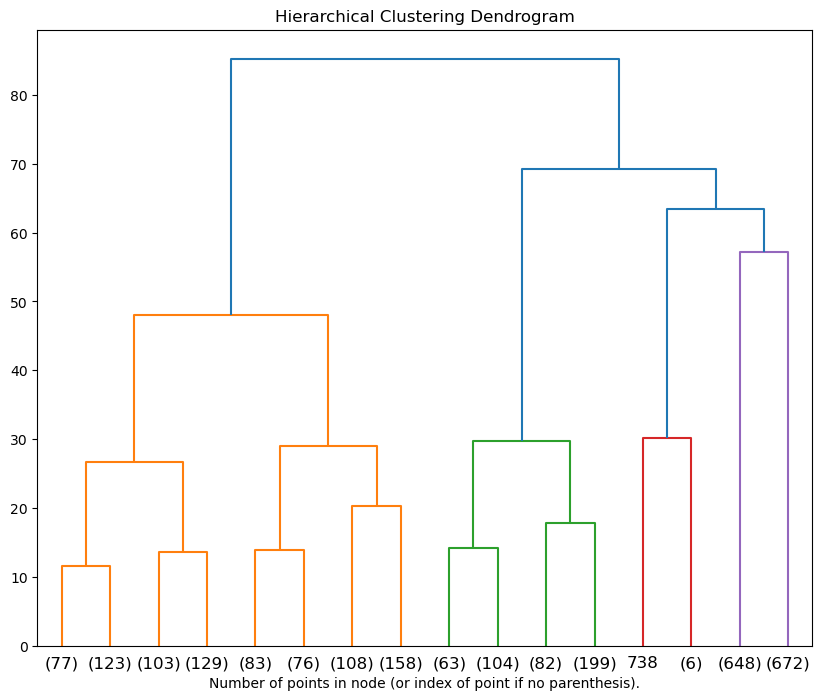

In [23]:
# Построим дендрограмму для иерархической кластеризации
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    dendrogram(linkage_matrix, **kwargs)

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(df_ss)
plt.figure(figsize=(10, 8))
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [24]:
# Вычислим значения инерции и силуэта для различного количества кластеров
inertia = []
silhouette = []
N = 15
for k in range(2, N):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(df_ss)
    preds = kmeans.predict(df_ss)
    inertia.append(np.sqrt(kmeans.inertia_))
    silhouette.append(silhouette_score(df_ss, preds))

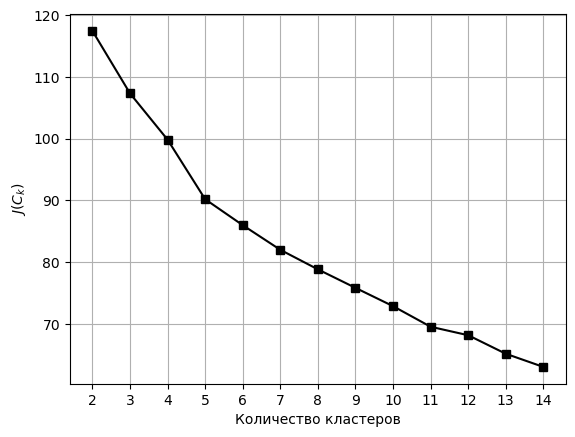

In [25]:
# График для инерции
plt.plot(range(2, N), inertia, marker='s', color='k')
plt.xticks(range(2, N))
plt.xlabel('Количество кластеров')
plt.grid()
plt.ylabel('$J(C_k)$');

На графике не прослеживается чёткого локтя

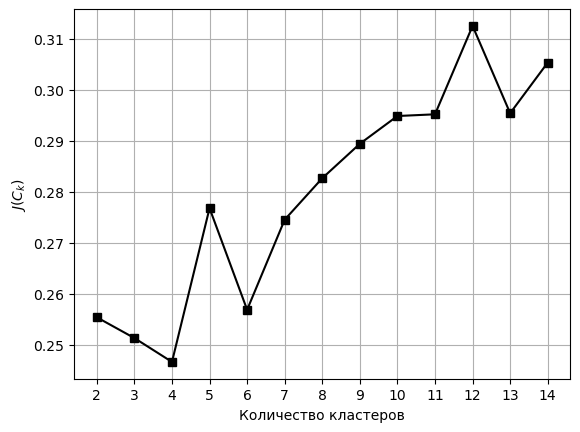

In [26]:
# График для силуэта
plt.plot(range(2, N), silhouette, marker='s', color='k')
plt.xticks(range(2, N))
plt.xlabel('Количество кластеров')
plt.grid()
plt.ylabel('$J(C_k)$');

Наблюдаем пики на при разбиении на 5, 8 и 11 кластеров

Text(0.5, 1.0, 'Hierarchical (scikit-learn)')

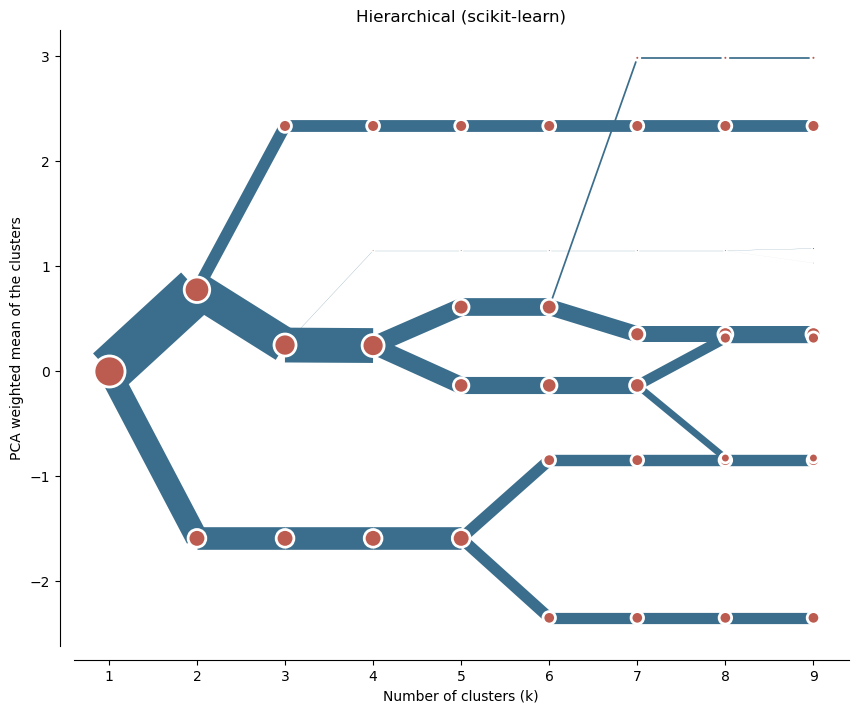

In [27]:
# Посмотрим на кластерную диаграмму
cgram = Clustergram(range(1, 10), method='hierarchical', linkage='ward')
cgram.fit(df_ss)

ax = cgram.plot(
    figsize=(10, 8),
    line_style=dict(color=ugg.COLORS[1]),
    cluster_style={"color": ugg.COLORS[2]},
)
ax.yaxis.grid(False)
sns.despine(offset=10)
ax.set_title('Hierarchical (scikit-learn)')

In [28]:
# Создадим объект класса TSNE
tsne = TSNE(n_components=2, random_state=42)
# Преобразуем данные
df_tsne = tsne.fit_transform(df_ss)

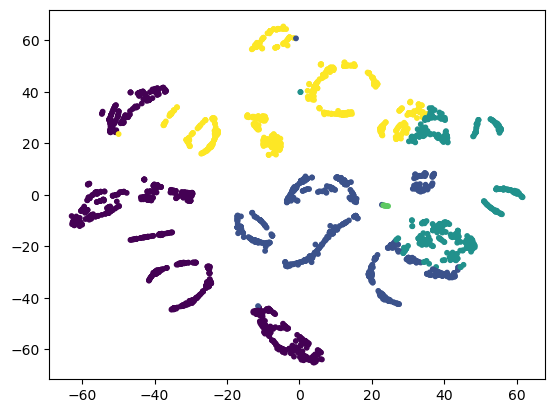

In [29]:
# Визуализируем разбиение на 5 кластеров с помощью Агломеративной кластеризации
clustering = AgglomerativeClustering(n_clusters=5).fit(df_ss)
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], s=10, c=clustering.labels_)

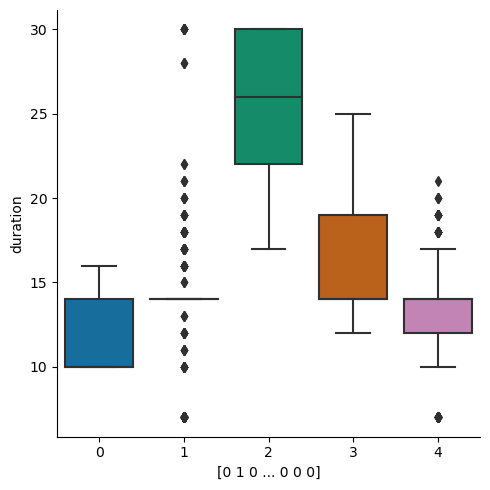

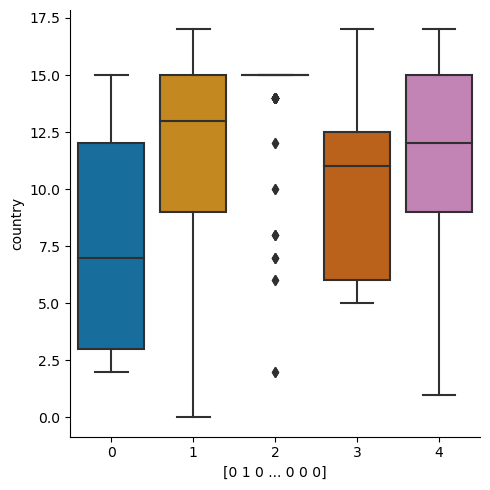

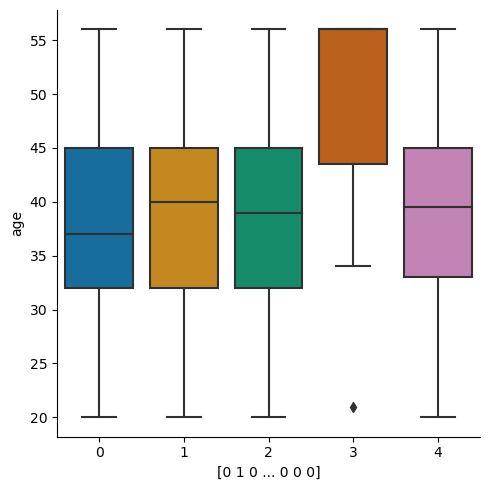

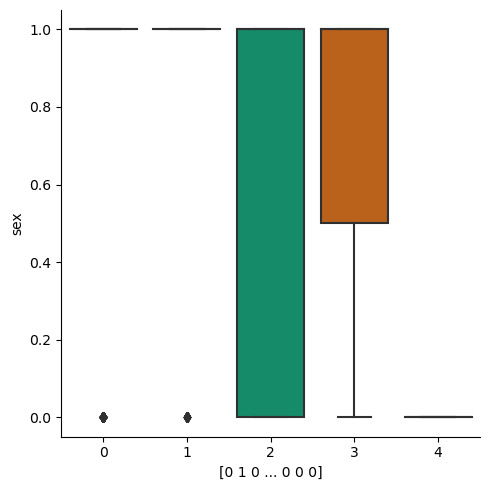

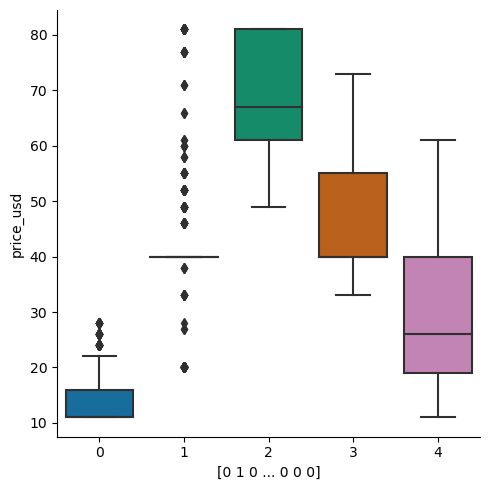

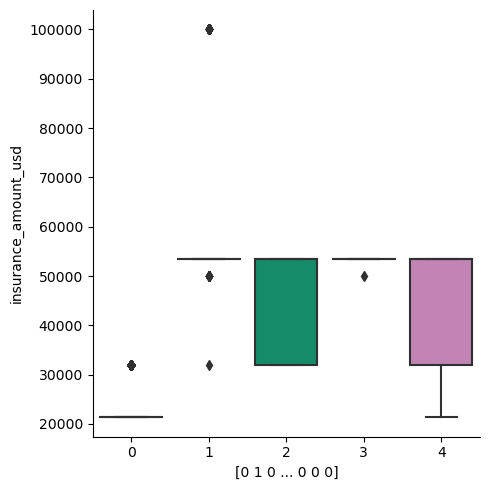

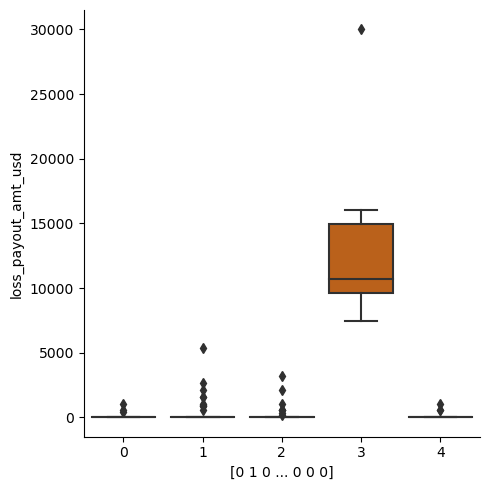

In [30]:
# Посмотрим на графики распределения признаков в зависимости от кластера

def boxplot(df, column):
    sns.catplot(kind="box", data=df,
                y=column,
                x=clustering.labels_,
                palette="colorblind", sharey=False)
    plt.tight_layout()
    plt.show()
    

columns = df.columns
for column in columns:
    boxplot(df, column)
